In [43]:
### Creating Combat Log Table

In [44]:
# what needs to happen is that a table needs to be created that stores each turn in combat and the actions that happened in that turn.
# the table should have the following columns:

# create the table in the form of a dataframe
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt


# create the table
combat_log = pd.DataFrame(columns=[
                                   'Combat Round',
                                   'Action Number',
                                   'Action Time', # action, bonus action, reaction, etc
                                   'Action Name', # attack, cast spell, dodge, etc
                                   'Action Type', # attack, support, heal, control, etc
                                   'Target',
                                   'Action Result',
                                   'Current Allied Ability Check',
                                   'Current Allied Attack Roll',
                                   'Current Allied Saving Throw',
                                   'Current Allied Damage Roll',
                                   'Current Enemy Ability Check',
                                   'Current Enemy Attack Roll',
                                   'Current Enemy Saving Throw',
                                   'Current Enemy Damage Roll',
                                   ])

In [45]:
import Species
import Backgrounds
import Armor_and_Weapons
import Dice_Rolls
import Establishing_Hierarchy
import CHARACTER_CREATOR
import Monsters

import Character_Actions

In [46]:
def generate_situation(character_num):
    print('generating situation...')

    # for the number of characters, randomly generate a Player_Character using Random_Character()
    entities = []
    print('generating characters...')
    for i in range(character_num):
        entities.append(CHARACTER_CREATOR.Random_Character())

    # for the number of entities, within each entity's flesh out the Active_Conditions and Circumstances dictionaries
    for entity in range(len(entities)):
        other_entities = entities.copy()
        other_entities.pop(entity)
        

        # I want to add a key for each other entity in the Active_Conditions dictionaries
        for other_entity in range(len(other_entities)):
            entities[entity].Active_Conditions[str(entities[other_entity])] = []
            entity_name = str(entities[other_entity].Name)
            entities[entity].Circumstances['Attack Rolls'][entity_name] = None

            #entities[entity].Circumstances['Attack Rolls'][entity_name] = 'placeholder'
            #print(entities[other_entity].Name)
        self_name = str(entities[entity].Name)
        entities[entity].Circumstances['Attack Rolls'][self_name] = None
    return entities


def generate_combat(character_num):
    print('generating combat...')

    combat_log_new = pd.DataFrame(columns=[
                                   'Combat Round',
                                   'Action Time', # action, bonus action, reaction, etc
                                   'Action Name', # attack, cast spell, dodge, etc
                                   'Action Type', # attack, support, heal, control, etc
                                   'Target',
                                   'Action Result',
                                   'Current Allied Ability Check',
                                   'Current Allied Attack Roll',
                                   'Current Allied Saving Throw',
                                   'Current Allied Damage Roll',
                                   'Current Enemy Ability Check',
                                   'Current Enemy Attack Roll',
                                   'Current Enemy Saving Throw',
                                   'Current Enemy Damage Roll',
                                   ])
    # create situation
    combat_situation = generate_situation(character_num)
    

    print('adding action options...')
    for entity in range(len(combat_situation)):
        combat_situation[entity].Actions['None'] = Character_Actions.No_Action(combat_situation[entity],combat_situation,combat_log_new)
        combat_situation[entity].Bonus_Actions['None'] = Character_Actions.No_Bonus_Action(combat_situation[entity],combat_situation,combat_log_new)
        combat_situation[entity].Actions['Attack'] = Character_Actions.Attack_Action(combat_situation[entity],combat_situation,combat_log_new)
        combat_situation[entity].Actions['Dodge'] = Character_Actions.Dodge_Action(combat_situation[entity],combat_situation,combat_log_new)
        combat_situation[entity].Actions['Help'] = Character_Actions.Help_Action(combat_situation[entity],combat_situation,combat_log_new)
        combat_situation[entity].Free_Actions['Move'] = Character_Actions.Move(combat_situation[entity],combat_situation,combat_log_new)
        Character_Actions.Equip_Weapon(combat_situation[entity],Character_Actions.Choose_Random_Weapon(combat_situation[entity]))

        # assign a unique location to each entity within a 12x12 grid
        combat_situation[entity].Location['X'] = np.random.randint(0,12)
        combat_situation[entity].Location['Y'] = np.random.randint(0,12)
        combat_situation[entity].Location['Z'] = 0
    
    # print the locations of each creature using a plot
    print('plotting locations...')
    plt.figure(figsize=(12,12))
    for entity in range(len(combat_situation)):
        plt.scatter(combat_situation[entity].Location['X'],combat_situation[entity].Location['Y'],label=combat_situation[entity].Name)
    plt.legend()
    plt.grid(True)
    plt.xlim(0,12)
    plt.ylim(0,12)
    plt.show()

    combat_round = 0
    combat_log_new['Combat Round'] = combat_round
    

    def take_turn(combat_log_new,character):
        # need to decide which action_type to take first: Actions or Bonus_Actions
        action_types = ['Actions','Bonus_Actions','Movement']
            # Move Splitting
            # Free Action
            # Object Interaction
        first_action_type = np.random.choice(action_types)
        # choose a second action type from the list minus the first action type
        second_action_type = np.random.choice([action for action in action_types if action != first_action_type])
        third_action_type = np.random.choice([action for action in action_types if action != first_action_type and action != second_action_type])

        if first_action_type == 'Actions':
            first_action = np.random.choice(['None','Attack','Dodge','Help'])
            new_turn = combat_situation[character].Actions[first_action]
        elif first_action_type == 'Bonus_Actions':
            first_action = np.random.choice(['None'])
            new_turn = combat_situation[character].Bonus_Actions[first_action]
        elif first_action_type == 'Movement':
            new_turn = combat_situation[character].Free_Actions['Move']
                
        if second_action_type == 'Actions':
            second_action = np.random.choice(['None','Attack','Dodge','Help'])
            new_turn = pd.concat([new_turn, combat_situation[character].Actions[second_action]], ignore_index=True, axis=0)
        elif second_action_type == 'Bonus_Actions':
            second_action = np.random.choice(['None'])
            new_turn = pd.concat([new_turn, combat_situation[character].Bonus_Actions[second_action]], ignore_index=True, axis=0)
        elif second_action_type == 'Movement':
            new_turn = pd.concat([new_turn, combat_situation[character].Free_Actions['Move']], ignore_index=True, axis=0)        
        
        if third_action_type == 'Actions':
            third_action = np.random.choice(['None','Attack','Dodge','Help'])
            new_turn = pd.concat([new_turn, combat_situation[character].Actions[third_action]], ignore_index=True, axis=0)
        elif third_action_type == 'Bonus_Actions':
            third_action = np.random.choice(['None'])
            new_turn = pd.concat([new_turn, combat_situation[character].Bonus_Actions[third_action]], ignore_index=True, axis=0)
        elif third_action_type == 'Movement':
            new_turn = pd.concat([new_turn, combat_situation[character].Free_Actions['Move']], ignore_index=True, axis=0)            



        #new_round = combat_situation[character].first_action_type[first_action]
        #new_round = pd.concat([new_round, combat_situation[character].second_action_type[second_action]], ignore_index=True, axis=0)


        #action = np.random.choice(['None','Attack','Dodge'])
        #bonus_action = np.random.choice(['None'])
        #new_round = combat_situation[character].Actions[action]
        #combat_log_new = pd.concat([combat_log_new, new_round], ignore_index=True, axis=0)
        return new_turn

    print('taking turns...')
    for entity in range(len(combat_situation)):
        combat_log_new = pd.concat([combat_log_new,take_turn(combat_log_new,entity)], ignore_index=True, axis=0)


    combat_log_new = combat_log_new.reindex(columns=['Combat Round'] + list(combat_log_new.columns[1:][combat_log_new.columns[1:].str.contains('Acting True')]) + list(combat_log_new.columns[1:][combat_log_new.columns[1:].str.contains('Current_HP')]) + list(combat_log_new.columns[1:][~combat_log_new.columns[1:].str.contains('Acting True') & ~combat_log_new.columns[1:].str.contains('Current_HP')]))
    
    return combat_log_new


In [47]:
# remove the number of columns limit
pd.set_option('display.max_columns', None)

generating combat...
generating situation...
generating characters...
Character_Creator - Random Character Function - Class Choice:  <module 'Bard' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Bard.py'>
Create Character Function - Class: <module 'Bard' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Bard.py'>
Character_Creator - Random Character Function - Class Choice:  <module 'Bard' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Bard.py'>
Create Character Function - Class: <module 'Bard' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Bard.py'>
Character_Creator - Random Character Function - Class Choice:  <module 'Barbarian' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Barbarian.py'>
Create Character Function - Class: <module 'Barbarian' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Barbarian.py'>
Character_Creator - Random Character Function - Class Choi

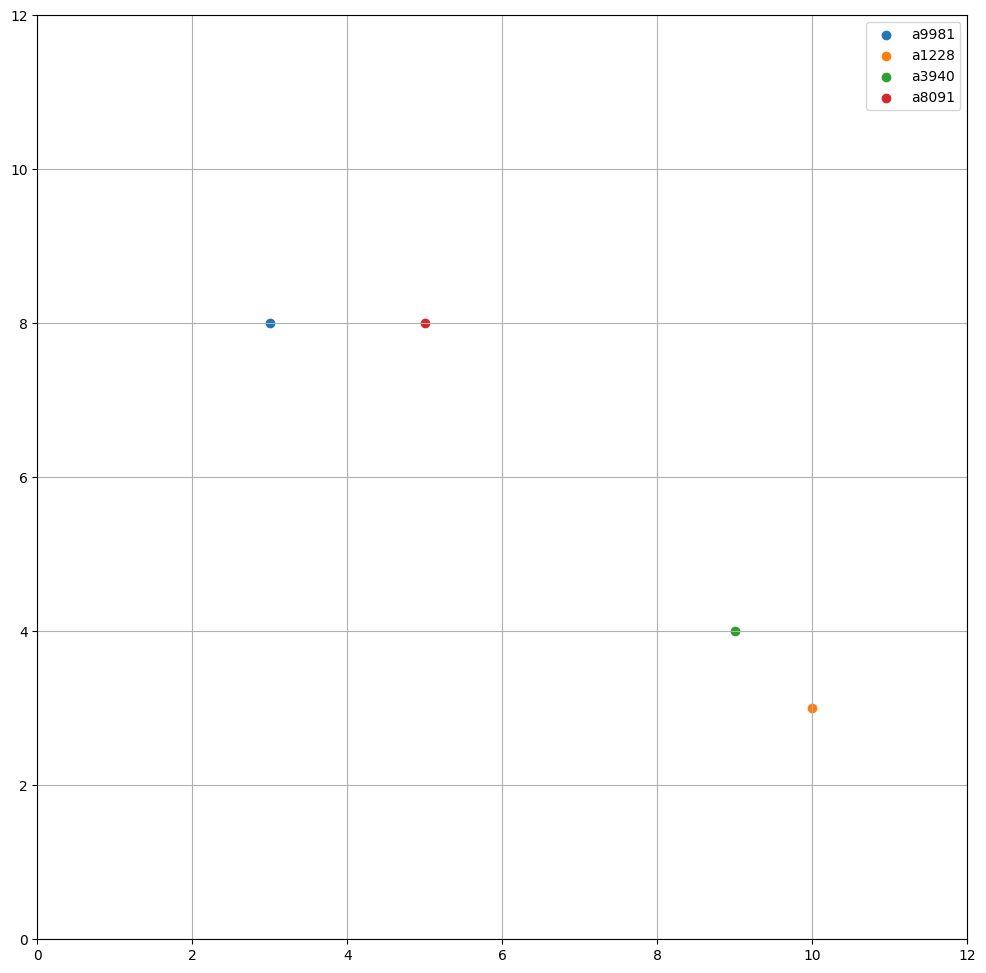

taking turns...


,Combat Round,a9981 Acting True,a1228 Acting True,a3940 Acting True,a8091 Acting True,a9981 Current_HP,a1228 Current_HP,a3940 Current_HP,a8091 Current_HP,Action Time,Action Name,Action Type,Target,Action Result,Current Allied Ability Check,Current Allied Attack Roll,Current Allied Saving Throw,Current Allied Damage Roll,Current Enemy Ability Check,Current Enemy Attack Roll,Current Enemy Saving Throw,Current Enemy Damage Roll,Action Number,a9981 Temp_HP,a9981 Size,a9981 Walking Speed,a9981 Flying Speed,a9981 Str_Score,a9981 Dex_Score,a9981 Con_Score,a9981 Int_Score,a9981 Wis_Score,a9981 Cha_Score,a9981 Active_Conditions,a9981 Concentrating,a9981Location X,a9981Location Y,a9981Location Z,a1228 Temp_HP,a1228 Size,a1228 Walking Speed,a1228 Flying Speed,a1228 Str_Score,a1228 Dex_Score,a1228 Con_Score,a1228 Int_Score,a1228 Wis_Score,a1228 Cha_Score,a1228 Active_Conditions,a1228 Concentrating,a1228Location X,a1228Location Y,a1228Location Z,a3940 Temp_HP,a3940 Size,a3940 Walking Speed,a3940 Flying Speed,a3940 Str_Score,a3940 Dex_Score,a3940 Con_Score,a3940 Int_Score,a3940 Wis_Score,a3940 Cha_Score,a3940 Active_Conditions,a3940 Concentrating,a3940Location X,a3940Location Y,a3940Location Z,a8091 Temp_HP,a8091 Size,a8091 Walking Speed,a8091 Flying Speed,a8091 Str_Score,a8091 Dex_Score,a8091 Con_Score,a8091 Int_Score,a8091 Wis_Score,a8091 Cha_Score,a8091 Active_Conditions,a8091 Concentrating,a8091Location X,a8091Location Y,a8091Location Z
0,0,1.0,0.0,0.0,0.0,10.0,9.0,12.0,12.0,Bonus Action,None,Passive,a9981,None,<Dice_Rolls.Ability_Check object at 0x00000210...,<Dice_Rolls.Attack_Roll object at 0x0000021058...,<Dice_Rolls.Saving_Throw object at 0x000002105...,<Dice_Rolls.Damage_Roll object at 0x0000021058...,<Dice_Rolls.Ability_Check object at 0x00000210...,<Dice_Rolls.Attack_Roll object at 0x0000021058...,<Dice_Rolls.Saving_Throw object at 0x000002105...,<Dice_Rolls.Damage_Roll object at 0x0000021058...,Undetermined,0.0,Medium,30.0,0.0,9.0,14.0,11.0,13.0,15.0,16.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,10.0,13.0,8.0,12.0,15.0,14.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,10.0,13.0,17.0,8.0,14.0,12.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,10.0,15.0,16.0,13.0,12.0,8.0,NaN,False,0.0,0.0,0.0
1,0,1.0,0.0,0.0,0.0,10.0,5.0,12.0,12.0,Move,Move,Mobility,a9981,Moved,<Dice_Rolls.Ability_Check object at 0x00000210...,<Dice_Rolls.Attack_Roll object at 0x0000021058...,<Dice_Rolls.Saving_Throw object at 0x000002105...,<Dice_Rolls.Damage_Roll object at 0x0000021058...,<Dice_Rolls.Ability_Check object at 0x00000210...,<Dice_Rolls.Attack_Roll object at 0x0000021058...,<Dice_Rolls.Saving_Throw object at 0x000002105...,<Dice_Rolls.Damage_Roll object at 0x0000021058...,Undetermined,0.0,Medium,30.0,0.0,9.0,14.0,11.0,13.0,15.0,16.0,NaN,False,-16.0,30.0,0.0,0.0,Medium,30.0,0.0,10.0,13.0,8.0,12.0,15.0,14.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,10.0,13.0,17.0,8.0,14.0,12.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,10.0,15.0,16.0,13.0,12.0,8.0,NaN,False,0.0,0.0,0.0
2,0,1.0,0.0,0.0,0.0,10.0,9.0,12.0,12.0,Action,None,Passive,a9981,None,<Dice_Rolls.Ability_Check object at 0x00000210...,<Dice_Rolls.Attack_Roll object at 0x0000021058...,<Dice_Rolls.Saving_Throw object at 0x000002105...,<Dice_Rolls.Damage_Roll object at 0x0000021058...,<Dice_Rolls.Ability_Check object at 0x00000210...,<Dice_Rolls.Attack_Roll object at 0x0000021058...,<Dice_Rolls.Saving_Throw object at 0x000002105...,<Dice_Rolls.Damage_Roll object at 0x0000021058...,Undetermined,0.0,Medium,30.0,0.0,9.0,14.0,11.0,13.0,15.0,16.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,10.0,13.0,8.0,12.0,15.0,14.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,10.0,13.0,17.0,8.0,14.0,12.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,10.0,15.0,16.0,13.0,12.0,8.0,NaN,False,0.0,0.0,0.0
3,0,0.0,1.0,0.0,0.0,10.0,5.0,12.0,12.0,Bonus Action,None,Passive,a1228,None,<Dice_Rolls.Ability_Check object at 0x00000210...,<Dice_Rolls.Attack_Roll object at 0x0000021058...,<Dice_Rolls.Saving_Throw object at 0x000002105...,<Dice_Rolls.D

In [48]:
generate_combat(4)